## Load documents with IDs

In [11]:
import json

with open('/app/Law_corpus/documents-with-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

In [12]:
documents[0]

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 1',
 'title': 'Phạm vi điều chỉnh',
 'content': 'Luật này quy định về hệ thống giáo dục quốc dân; cơ sở giáo dục, nhà giáo, người học; quản lý nhà nước về giáo dục; quyền và trách nhiệm của cơ quan, tổ chức, cá nhân liên quan đến hoạt động giáo dục. ',
 'id': '75a9286e'}

## Load ground truth

In [13]:
import pandas as pd

df_ground_truth = pd.read_csv('./evaluate/ground-truth-data.csv')
ground_truth = df_ground_truth.to_dict(orient='records')

In [14]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [15]:
doc_idx = {d['id']: d for d in documents}
doc_idx['a0fcdc5b']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương II',
 'article_number': 'Điều 26',
 'title': 'Cơ sở giáo dục mầm non',
 'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
 'id': 'a0fcdc5b'}

## Index data

In [16]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("truro7/vn-law-embedding", truncate_dim = 768) #truncate_dim = 768

Invalid model-index. Not loading eval results into CardData.
Invalid model-index. Not loading eval results into CardData.


In [17]:
from elasticsearch import Elasticsearch
# es_client = Elasticsearch('http://localhost:9200') 
es_client = Elasticsearch('http://elasticsearch_compose:9200') #connect to docker compose network if runinng from dockerfile container 
# es_client.info()

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "law_title": {"type": "keyword"},                
            "law_number": {"type": "keyword"},               
            "chapter_title": {"type": "keyword"},            
            "article_number": {"type": "keyword"},            
            "title": {"type": "text"},                        
            "content": {"type": "text"},   
            "id": {"type": "text"},   
            "title_content_vector": {                                 
                "type": "dense_vector",
                "dims": 768,                                 
                "index": True,
                "similarity": "cosine"
            }                
        }
    }
}

index_name = "legal_documents_ids"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'legal_documents_ids'})

In [18]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    title = doc['title']
    content = doc['content']
    doc['title_content_vector'] = model.encode(title + ' ' + content)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/314 [00:00<?, ?it/s]

## Retrieval

In [19]:
def elastic_search_knn(field, vector, law_title):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 3,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "law_title": law_title
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["law_title", "law_number", "chapter_title", "article_number", "title", "content","id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def title_content_vector_knn(q):
    questions = q['generated_question']
    law_title = q['law_title']

    v_q = model.encode(questions)

    return elastic_search_knn('title_content_vector', v_q, law_title)


In [20]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [21]:
title_content_vector_knn({'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'})

[{'article_number': 'Điều 26',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương II',
  'id': 'a0fcdc5b',
  'title': 'Cơ sở giáo dục mầm non',
  'law_title': 'Luật Giáo Dục',
  'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. '},
 {'article_number': 'Điều 47',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương III',
  'id': 'ff030746',
  'title': 'Loại hình nhà trường trong hệ thống giáo dục quốc dân',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà trường trong hệ thống giáo dục quốc dân được tổ chức theo các loại hình sau đây: a) Trường công lập do Nhà nước đầu tư, bảo đảm điều kiện hoạt động và đại diện chủ sở hữu; b) Trường dân lập do cộng đồng dân cư ở cơ sở gồm tổ chức và cá

## The RAG flow

In [25]:
import re
import time
from googletrans import Translator

translator = Translator()

def vietnamese_to_english(text):
    """
    Translates Vietnamese text to English using the googletrans library.
    """
    # Translate the text
    translation = translator.translate(text, src='vi', dest='en')
    
    # Return the translated text
    return translation.text

def english_to_vietnamese(text):
    """
    Translates English text to Vietnamese using the googletrans library.
    """
    # Translate the text
    translation = translator.translate(text, src='en', dest='vi')
    
    # Return the translated text
    return translation.text

In [29]:
ground_truth[0]['generated_question']

'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?'

In [47]:
import re
import time
from googletrans import Translator

translator = Translator()

def clean_text(text):
    """
    Cleans text by removing non-printable characters, normalizing whitespace,
    and specifically handling problematic semicolons.
    """
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single spaces
    text = ''.join(c for c in text if c.isprintable())  # Remove non-printable characters
    text = text.replace(';', ',')  # Replace semicolons with commas
    return text

def undo_clean_text(text):
    """
    Reverses the semicolon replacement done by clean_text.
    """
    text = text.replace(',', ';')  # Replace commas back to semicolons
    return text

def translate_in_chunks(text, chunk_size=4000):
    """
    Translates text in smaller chunks to avoid potential issues with large text.
    """
    if len(text) <= chunk_size:
        return vietnamese_to_italian(text)

    chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
    translated_chunks = [vietnamese_to_italian(chunk) for chunk in chunks]
    return " ".join(translated_chunks)

def vietnamese_to_italian(text):
    """
    Translates Vietnamese text to Italian using the googletrans library.
    Handles potential None values returned by the translator.
    """
    translation = translator.translate(text, src='vi', dest='it')
    
    # Return the translated text
    return translation.text

def italian_to_vietnamese(text):
    """
    Translates Italian text to Vietnamese using the googletrans library.
    No error handling is applied, so any issues will raise exceptions.
    """
    # Translate the text
    translation = translator.translate(text, src='it', dest='vi')
    
    # Return the translated text
    return translation.text

def build_prompt(query, search_results):
    prompt_template = """
Sei un assistente di ricerca legale. Rispondi alla DOMANDA basandoti sul CONTESTO del database legale.
Utilizza solo i fatti dal CONTESTO quando rispondi alla DOMANDA.

CONTESTO:
{context}
""".strip()

    # Translate the query to Italian
    translated_query = vietnamese_to_italian(query)

    context = ""
    # Prioritize the first document (best match)
    if search_results:
        first_doc = search_results[0]
        # Translate each field, cleaning the text first
        translated_law_title = vietnamese_to_italian(clean_text(first_doc['law_title']))
        translated_title = vietnamese_to_italian(clean_text(first_doc['title']))
        translated_content = translate_in_chunks(clean_text(first_doc['content']))
        translated_content = undo_clean_text(translated_content)

        # Add the first document to the context with a note about its priority
        context += f"PRIMA LEGGE (MIGLIOR RISULTATO):\n"
        context += f"titolo di legge: {translated_law_title}\n titolo: {translated_title}\n legge: {translated_content}\n\n"

    # Add the remaining documents to the context
    for doc in search_results[1:]:
        # Translate each field, cleaning the text first
        translated_law_title = vietnamese_to_italian(clean_text(doc['law_title']))
        translated_title = vietnamese_to_italian(clean_text(doc['title']))
        translated_content = translate_in_chunks(clean_text(doc['content']))
        translated_content = undo_clean_text(translated_content)

        context += f"titolo di legge: {translated_law_title}\n titolo: {translated_title}\n legge: {translated_content}\n\n"

    # Use the correct key 'question' here
    prompt = prompt_template.format(question=translated_query, context=context).strip()
    return prompt

In [31]:
context = build_prompt(ground_truth[0], title_content_vector_knn(ground_truth[0]))
print(italian_to_vietnamese(context))

Bạn là một trợ lý nghiên cứu pháp lý.Trả lời câu hỏi dựa trên bối cảnh của cơ sở dữ liệu pháp lý.
Chỉ sử dụng các sự kiện từ bối cảnh khi bạn trả lời câu hỏi.

BỐI CẢNH:
Luật đầu tiên (kết quả tốt nhất):
Tiêu đề của pháp luật: Luật giáo dục
Tiêu đề: Các tổ chức giáo dục ở độ tuổi mẫu giáo
Luật: Các tổ chức giáo dục Fleechool bao gồm: 1. Mẫu giáo;Nhóm trẻ em độc lập từ 03 tháng đến 03 tuổi;2. Mẫu giáo;Lớp học mẫu giáo độc lập chấp nhận trẻ em từ 03 đến 06 tuổi;Tuổi;3. Mẫu giáo;Các lớp học mầm non độc lập là các tổ chức giáo dục kết hợp anidergartens và năm;Đưa trẻ em từ 03 tháng đến 06 năm.

Tiêu đề của pháp luật: Luật giáo dục
Tiêu đề: Loại trường trong Hệ thống Giáo dục Quốc gia
Luật: 1đảm bảo điều kiện hoạt động và đại diện của chủ sở hữu;b) do cộng đồng cơ bản;bao gồm các tổ chức và cá nhân trong ấp;Làng;Làng;Phum;con sóc;Đô thị;Các phòng ban và thành phố để đầu tư vào các cấu trúc để xây dựng và đảm bảo điều kiện hoạt động.c) Các trường tư thục đầu tư bởi các nhà đầu tư quốc gia ho

In [28]:
from transformers import MambaConfig, MambaForCausalLM, AutoTokenizer
import torch

mamba_model_name = "DeepMount00/mamba_790_hf_qa"
mamba_tokenizer = AutoTokenizer.from_pretrained(mamba_model_name)
mamba_model = MambaForCausalLM.from_pretrained(mamba_model_name, device_map={"": 0}).eval()

tokenizer_config.json:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/921 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.17G [00:00<?, ?B/s]

The fast path is not available because one of `(selective_state_update, selective_scan_fn, causal_conv1d_fn, causal_conv1d_update, mamba_inner_fn)` is None. Falling back to the sequential implementation of Mamba, as use_mambapy is set to False. To install follow https://github.com/state-spaces/mamba/#installation and https://github.com/Dao-AILab/causal-conv1d. For the mamba.py backend, follow https://github.com/alxndrTL/mamba.py.


generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [32]:
def llm(context, question):
    device = "cuda:0"
    # Hybrid prefix: Start with the working Italian, then transition to English instructions

    prompt = f""" ##CONTESTO: {context}\n##DOMANDA: {question}\n"""

    input_ids = mamba_tokenizer([prompt], return_tensors="pt").to(device)

    generate_ids = mamba_model.generate(**input_ids, max_length=2000, eos_token_id=8112)

    answer = mamba_tokenizer.batch_decode(generate_ids)

    try:
        final_answer = answer[0].split("##RISPOSTA: ")[1].split("##END")[0].strip("\n")
    except IndexError:
        final_answer = ""
    return final_answer

## Trying to fix None Type error from Translation

In [34]:
search_results = title_content_vector_knn(ground_truth[0])
search_results

[{'article_number': 'Điều 26',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương II',
  'id': 'a0fcdc5b',
  'title': 'Cơ sở giáo dục mầm non',
  'law_title': 'Luật Giáo Dục',
  'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. '},
 {'article_number': 'Điều 47',
  'law_number': 'Luật số: 43/2019/QH14',
  'chapter_title': 'Chương III',
  'id': 'ff030746',
  'title': 'Loại hình nhà trường trong hệ thống giáo dục quốc dân',
  'law_title': 'Luật Giáo Dục',
  'content': '1. Nhà trường trong hệ thống giáo dục quốc dân được tổ chức theo các loại hình sau đây: a) Trường công lập do Nhà nước đầu tư, bảo đảm điều kiện hoạt động và đại diện chủ sở hữu; b) Trường dân lập do cộng đồng dân cư ở cơ sở gồm tổ chức và cá

In [141]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [39]:
vietnamese_to_italian("con mèo siêu mập")
print(italian_to_vietnamese('Gatto super grasso'))

Mèo siêu béo


In [35]:
def rag_test(query: str) -> str:
    search_results = title_content_vector_knn(query)
    print("Search Results:", search_results)

    # Translate the query to Italian before passing it to build_prompt
    translated_query = vietnamese_to_italian(query['generated_question'])
    print("Translated Query:", translated_query)

    context = build_prompt(translated_query, search_results)  # Context is built using the translated query
    print("Context:", context)

    answer = llm(context, translated_query)
    print("LLM Answer:", answer)

    # Combine the formatted search results and translated answer with a newline separator
    final_answer = italian_to_vietnamese(answer)
    print("Final Answer:", final_answer)

    return final_answer

In [48]:
def format_search_results(search_results):
    """
    Formats the search results into a readable string.

    Args:
        search_results (list): A list of dictionaries, where each dictionary is a search result.

    Returns:
        str: The formatted search results string.
    """
    formatted_results = ""
    for doc in search_results:
        formatted_results += (
            f"{doc['law_title']}\n"
            f"{doc['law_number']}\n"
            f"{doc['article_number']}\n"
            f"{doc['title']}\n"
            f"{doc['content']}\n\n"
        )
    return formatted_results.strip()

def rag(query: str) -> str:
    search_results = title_content_vector_knn(query)

    # Translate the query to Italian before passing it to build_prompt
    translated_query = vietnamese_to_italian(query['generated_question'])

    context = build_prompt(translated_query, search_results)  # Context is built using the translated query

    answer = llm(context, translated_query)

    # Combine the formatted search results and translated answer with a newline separator
    final_answer = italian_to_vietnamese(answer)

    return final_answer

def rag_with_search(query: str) -> str:
    search_results = title_content_vector_knn(query)
    search_results_str = format_search_results(search_results)

    # Translate the query to Italian before passing it to build_prompt
    translated_query = vietnamese_to_italian(query['generated_question'])

    context = build_prompt(translated_query, search_results)  # Context is built using the translated query

    answer = llm(context, translated_query)

    # Combine the formatted search results and translated answer with a newline separator
    return print(f"{search_results_str}\n\n DeepMount00/mamba_790_hf_qa:{italian_to_vietnamese(answer)}")

In [49]:
rag(ground_truth[0])

The 'batch_size' argument of MambaCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.


'Các loại tổ chức mầm non được quy định trong luật giáo dục là: trường tư thục, trường công được đầu tư bởi tiểu bang, trường công, trường tư, các hoạt động, đào tạo, giáo dục, lớp học, phòng ban, khóa học, v.v.'

In [165]:
rag_with_search(ground_truth[-1])

Luật Hôn Nhân Và Gia Đình
Số: 52/2014/QH13
Điều 43
Tài sản riêng của vợ, chồng
1. Tài sản riêng của vợ, chồng gồm tài sản mà mỗi người có trước khi kết hôn; tài sản được thừa kế riêng, được tặng cho riêng trong thời kỳ hôn nhân; tài sản được chia riêng cho vợ, chồng theo quy định tại các điều 38, 39 và 40 của Luật này; tài sản phục vụ nhu cầu thiết yếu của vợ, chồng và tài sản khác mà theo quy định của pháp luật thuộc sở hữu riêng của vợ, chồng. 2. Tài sản được hình thành từ tài sản riêng của vợ, chồng cũng là tài sản riêng của vợ, chồng. Hoa lợi, lợi tức phát sinh từ tài sản riêng trong thời kỳ hôn nhân được thực hiện theo quy định tại khoản 1 Điều 33 và khoản 1 Điều 40 của Luật này.

 DeepMount00/mamba_790_hf_qa:Tài sản riêng của vợ chồng cô được coi là tài sản riêng của vợ chồng, người cũng bao gồm tài sản mà mỗi người có trước khi kết hôn, tài sản mà mỗi người có trước đám cưới, tài sản được thừa kế riêng với chồng e Theo các quy tắc của pháp luật, và các hoạt động phục vụ các nhu 

In [51]:
rag_with_search({'generated_question': 'chạy xe ngược chiều bị gì',
 'generated_answer': 'Nhà nước có trách nhiệm tổ chức quản lý, bảo trì, bảo vệ kết cấu hạ tầng giao thông đường bộ, bao gồm việc xây dựng quy hoạch, kế hoạch và chính sách phát triển giao thông đường bộ, cũng như thực hiện các chương trình quốc gia về an toàn giao thông đường bộ.',
 'doc_id': 'd2166e14',
 'law_title': 'Luật Giao Thông Đường Bộ'})

Luật Giao Thông Đường Bộ
Luật số: 23/2008/QH12
Điều 17
Tránh xe đi ngược chiều
1. Trên đường không phân chia thành hai chiều xe chạy riêng biệt, hai xe đi ngược chiều tránh nhau, người điều khiển phải giảm tốc độ và cho xe đi về bên phải theo chiều xe chạy của mình. 2. Các trường hợp nhường đường khi tránh nhau quy định như sau: a) Nơi đường hẹp chỉ đủ cho một xe chạy và có chỗ tránh xe thì xe nào ở gần chỗ tránh hơn phải vào vị trí tránh, nhường đường cho xe kia đi; b) Xe xuống dốc phải nhường đường cho xe đang lên dốc; c) Xe nào có chướng ngại vật phía trước phải nhường đường cho xe không có chướng ngại vật đi trước. 3. Xe cơ giới đi ngược chiều gặp nhau không được dùng đèn chiếu xa. 

Luật Giao Thông Đường Bộ
Luật số: 23/2008/QH12
Điều 15
Chuyển hướng xe
1. Khi muốn chuyển hướng, người điều khiển phương tiện phải giảm tốc độ và có tín hiệu báo hướng rẽ. 2. Trong khi chuyển hướng, người lái xe, người điều khiển xe máy chuyên dùng phải nhường quyền đi trước cho người đi bộ, người đi x

## 100 question for evaluate

In [167]:
doc_idx['75a9286e']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương I',
 'article_number': 'Điều 1',
 'title': 'Phạm vi điều chỉnh',
 'content': 'Luật này quy định về hệ thống giáo dục quốc dân; cơ sở giáo dục, nhà giáo, người học; quản lý nhà nước về giáo dục; quyền và trách nhiệm của cơ quan, tổ chức, cá nhân liên quan đến hoạt động giáo dục. ',
 'id': '75a9286e',
 'title_content_vector': array([-1.97882224e-02, -1.99339297e-02,  4.56860475e-02,  8.96888971e-02,
        -5.92795312e-02, -6.35427088e-02,  4.05403003e-02,  1.20414663e-02,
         1.30230516e-01,  3.74822877e-02,  7.43912440e-03,  8.62386171e-03,
         4.33983728e-02,  2.53979526e-02,  1.36169503e-02, -1.71789490e-02,
         6.61228448e-02,  7.36672133e-02, -5.86116761e-02,  9.18327495e-02,
        -1.52075256e-03,  4.18600067e-02,  3.99471521e-02,  8.13104771e-03,
         2.45093219e-02,  8.91548989e-05,  2.86348090e-02, -6.75837044e-03,
         1.57178324e-02,  5.52585609e-02,  1.1

## Cosine similarity metric

In [ ]:
law_content = 'Những quyền và trách nhiệm nào của cá nhân liên quan đến hoạt động giáo dục được quy định trong Luật này?'

rag_answer_llm = 'Học sinh chịu trách nhiệm về an toàn cho việc học tập, đào tạo, nghiên cứu và thúc đẩy truyền thống của các tổ chức giáo dục.'


v_llm = model.encode(rag_answer_llm)
v_orig = model.encode(law_content)

v_llm.dot(v_orig)

np.float32(0.65316844)

In [168]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [170]:
print(len(ground_truth))

101


In [172]:
ground_truth[0]

{'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'doc_id': 'a0fcdc5b',
 'law_title': 'Luật Giáo Dục'}

In [173]:
doc_idx['a0fcdc5b']

{'law_title': 'Luật Giáo Dục',
 'law_number': 'Luật số: 43/2019/QH14',
 'chapter_title': 'Chương II',
 'article_number': 'Điều 26',
 'title': 'Cơ sở giáo dục mầm non',
 'content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
 'id': 'a0fcdc5b',
 'title_content_vector': array([ 7.95298629e-03, -4.98195663e-02, -1.41766975e-02,  9.84302834e-02,
        -6.20751604e-02, -6.11004829e-02,  1.06136993e-01, -1.19053842e-02,
         3.72010469e-02, -7.81889558e-02, -5.54205850e-03, -3.55521473e-03,
         7.56526589e-02,  9.28157344e-02,  1.14507992e-02,  3.76506476e-03,
         5.42252045e-03, -7.10310601e-03,  7.21576810e-03,  2.13801078e-02,
         2.43167114e-02, -1.93169750e-02,  2.54439772e-03,  1.40028857e-02,
        -

In [ ]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    rag_answer_llm = rag(rec)
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    law_content = original_doc['content']
    

    answers[i] = {
        'law_content': law_content,
        'generated_question': rec['generated_question'],
        'rag_answer_llm': rag_answer_llm,
        'generated_answer': rec['generated_answer'],

    }

In [52]:
len(answers)

NameError: name 'answers' is not defined

In [181]:
answers.values()

dict_values([{'law_content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ', 'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?', 'rag_answer_llm': 'Các loại tổ chức mầm non được quy định trong luật giáo dục là: 1. Mẫu giáo;2. Mẫu giáo / trẻ sơ sinh;3. Mẫu giáo / Tiểu học.', 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.'}, {'law_content': '1. Việc ly hôn giữa công dân Việt Nam với người nước ng

In [188]:
df = pd.DataFrame(answers.values())
# df.to_csv("DeepMount00_mamba_790_hf_qa_1_top_search.csv", index=False)
df.to_csv("DeepMount00_mamba_790_hf_qa.csv", index=False)



In [187]:
df

,law_content,generated_question,rag_answer_llm,generated_answer,document
0,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",Các loại hình cơ sở giáo dục mầm non được quy ...,Các loại viện giáo dục được quy định là: các v...,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",a0fcdc5b
1,1. Việc ly hôn giữa công dân Việt Nam với ngườ...,Nếu tôi là công dân Việt Nam kết hôn với người...,Bạn phải thực hiện các thủ tục như được chỉ ra...,Việc ly hôn giữa công dân Việt Nam với người n...,a2a23d08
2,"1. Cô, dì, chú, cậu, bác ruột không sống chung...","Khi nào cô, dì, chú, cậu, bác ruột có nghĩa vụ...","Nếu một người không sống với dì, chú, chú, chú...","Cô, dì, chú, cậu, bác ruột không sống chung vớ...",36501b98
3,1. Người tham gia giao thông phải chấp hành hi...,Tại nơi có cả biển báo hiệu cố định và báo hiệ...,Ở nơi có một báo cáo đường;Những người tham gi...,Tại nơi có biển báo hiệu cố định lại có báo hi...,4d5249af
4,1. Xe xin vượt phải có báo hiệu bằng đèn hoặc ...,Khi nào tôi được phép vượt xe bên phải thay vì...,Tôi không đủ thông tin để trả lời câu hỏi này.,Bạn được phép vượt xe bên phải trong các trườn...,7d030583
...,...,...,...,...,...
96,Luật này quy định chế độ hôn nhân và gia đình;...,Luật Hôn Nhân Và Gia Đình điều chỉnh những vấn...,Các vấn đề về hôn nhân và luật gia đình bao gồ...,Luật này quy định chế độ hôn nhân và gia đình;...,424554a8
97,1. Việc mang thai hộ vì mục đích nhân đạo phải...,Điều kiện để một cặp vợ chồng được nhờ người m...,Một cặp vợ chồng phải có sự đồng ý bằng văn bả...,Vợ chồng có quyền nhờ người mang thai hộ khi c...,04868edf
98,1. Cha mẹ là người đại diện theo pháp luật của...,Cha mẹ có quyền tự mình thực hiện giao dịch tà...,"Vâng, cha mẹ có quyền thực hiện giao dịch một ...",Cha hoặc mẹ có quyền tự mình thực hiện giao dị...,dc292a9c
99,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",Vợ chồng có nghĩa vụ gì đối với quyền tự do tí...,Các nghĩa vụ cho sự tự do của niềm tin và tôn ...,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",c8a7e8e1


In [185]:
results_mamba_qa = [None] * len(ground_truth)

for i, val in answers.items():
    results_mamba_qa[i] = val.copy()
    results_mamba_qa[i].update(ground_truth[i])

In [186]:
results_mamba_qa

[{'law_content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
  'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
  'rag_answer_llm': 'Các loại viện giáo dục được quy định là: các viện mầm non, tổ chức giáo dục mầm non, mẫu giáo, mẫu giáo, mẫu giáo.',
  'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
  'document': 'a0fcdc5b',
  'doc_id': 'a0fcdc5b',
  'law_title': 'Luật Giáo Dục'},
 {'law

In [53]:
import pandas as pd

In [54]:
df_mamba_qa = pd.read_csv("./DeepMount00_mamba_790_hf_qa_1_top_search.csv")
df_mamba_qa

,law_content,generated_question,rag_answer_llm,generated_answer,document
0,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",Các loại hình cơ sở giáo dục mầm non được quy ...,Các loại viện giáo dục được quy định là: các v...,"Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nh...",a0fcdc5b
1,1. Việc ly hôn giữa công dân Việt Nam với ngườ...,Nếu tôi là công dân Việt Nam kết hôn với người...,Bạn phải thực hiện các thủ tục như được chỉ ra...,Việc ly hôn giữa công dân Việt Nam với người n...,a2a23d08
2,"1. Cô, dì, chú, cậu, bác ruột không sống chung...","Khi nào cô, dì, chú, cậu, bác ruột có nghĩa vụ...","Nếu một người không sống với dì, chú, chú, chú...","Cô, dì, chú, cậu, bác ruột không sống chung vớ...",36501b98
3,1. Người tham gia giao thông phải chấp hành hi...,Tại nơi có cả biển báo hiệu cố định và báo hiệ...,Ở nơi có một báo cáo đường;Những người tham gi...,Tại nơi có biển báo hiệu cố định lại có báo hi...,4d5249af
4,1. Xe xin vượt phải có báo hiệu bằng đèn hoặc ...,Khi nào tôi được phép vượt xe bên phải thay vì...,Tôi không đủ thông tin để trả lời câu hỏi này.,Bạn được phép vượt xe bên phải trong các trườn...,7d030583
...,...,...,...,...,...
96,Luật này quy định chế độ hôn nhân và gia đình;...,Luật Hôn Nhân Và Gia Đình điều chỉnh những vấn...,Các vấn đề về hôn nhân và luật gia đình bao gồ...,Luật này quy định chế độ hôn nhân và gia đình;...,424554a8
97,1. Việc mang thai hộ vì mục đích nhân đạo phải...,Điều kiện để một cặp vợ chồng được nhờ người m...,Một cặp vợ chồng phải có sự đồng ý bằng văn bả...,Vợ chồng có quyền nhờ người mang thai hộ khi c...,04868edf
98,1. Cha mẹ là người đại diện theo pháp luật của...,Cha mẹ có quyền tự mình thực hiện giao dịch tà...,"Vâng, cha mẹ có quyền thực hiện giao dịch một ...",Cha hoặc mẹ có quyền tự mình thực hiện giao dị...,dc292a9c
99,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",Vợ chồng có nghĩa vụ gì đối với quyền tự do tí...,Các nghĩa vụ cho sự tự do của niềm tin và tôn ...,"Vợ, chồng có nghĩa vụ tôn trọng quyền tự do tí...",c8a7e8e1


## Evaluating 

In [ ]:
rag(ground_truth[10], model='gpt-3.5-turbo')

In [ ]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [ ]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record(ground_truth[10])

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [ ]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [ ]:
!head data/results-gpt35.csv

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [190]:
results_mamba_qa = df_mamba_qa.to_dict(orient='records')

In [191]:
record = results_mamba_qa[0]
record

{'law_content': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi. ',
 'generated_question': 'Các loại hình cơ sở giáo dục mầm non được quy định như thế nào trong Luật Giáo Dục?',
 'rag_answer_llm': 'Các loại viện giáo dục được quy định là: các viện mầm non, tổ chức giáo dục mầm non, mẫu giáo, mẫu giáo, mẫu giáo.',
 'generated_answer': 'Cơ sở giáo dục mầm non bao gồm: 1. Nhà trẻ, nhóm trẻ độc lập nhận trẻ em từ 03 tháng tuổi đến 03 tuổi; 2. Trường mẫu giáo, lớp mẫu giáo độc lập nhận trẻ em từ 03 tuổi đến 06 tuổi; 3. Trường mầm non, lớp mầm non độc lập là cơ sở giáo dục kết hợp nhà trẻ và mẫu giáo, nhận trẻ em từ 03 tháng tuổi đến 06 tuổi.',
 'document': 'a0fcdc5b'}

In [195]:
def compute_similarity(record):
    generated_answer = str(record['generated_answer'])  # Convert to string
    rag_answer_llm = str(record['rag_answer_llm'])    # Convert to string
    v_llm = model.encode(rag_answer_llm)
    v_orig = model.encode(generated_answer)
    return v_llm.dot(v_orig)

In [196]:
similarity = []

for record in tqdm(results_mamba_qa):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/101 [00:00<?, ?it/s]

In [197]:
df_mamba_qa['cosine'] = similarity
df_mamba_qa['cosine'].describe()

count    101.000000
mean       0.646146
std        0.232852
min       -0.047798
25%        0.539032
50%        0.713217
75%        0.817774
max        0.933885
Name: cosine, dtype: float64

In [198]:
import seaborn as sns

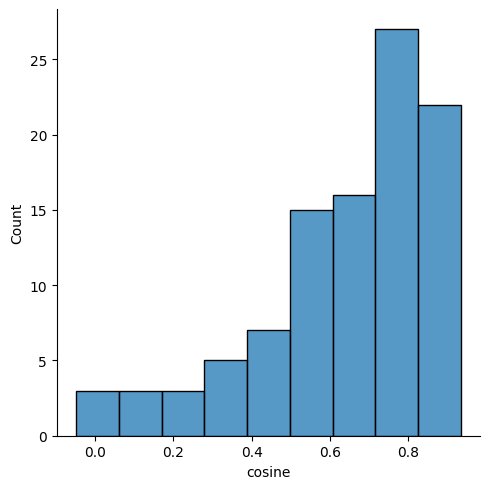

In [199]:
sns.displot(df_mamba_qa['cosine'])

### gpt-3.5-turbo

In [ ]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

In [ ]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

In [ ]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [ ]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [ ]:
process_record_4o_mini(ground_truth[10])

In [ ]:
results_gpt4omini = []

In [ ]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

In [ ]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [ ]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

In [ ]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

In [ ]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_mamba_qa['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [ ]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [ ]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [ ]:
samples = df_sample.to_dict(orient='records')

In [ ]:
record = samples[0]
record

In [ ]:
prompt = prompt1_template.format(**record)
print(prompt)

In [ ]:
answer = llm(prompt, model='gpt-4o-mini')

In [ ]:
import json

In [ ]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

In [ ]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [ ]:
df_evaluations = pd.DataFrame(json_evaluations)

In [ ]:
df_evaluations.Relevance.value_counts()

In [ ]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

In [ ]:
sample[4]

In [ ]:
prompt = prompt2_template.format(**record)
print(prompt)

In [ ]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

In [ ]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

In [ ]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [ ]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [ ]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

In [ ]:
samples[45]

## Saving all the data

## Translation evaluation